# Parallelizing Data Processing with Spark on Google Cloud

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

## Set-up

In [ ]:
# import
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


In [ ]:
# authenticating with with GCS Google Drive
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
# !mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/BD-CW


In [ ]:
# authenticate with the GCS to access Dataproc and AI-Platform
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [ ]:
# create a new Google Cloud project
PROJECT = 'bigdata-cw24-230048952'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = Ling-Yun.Huang@city.ac.uk
project = bigdata-cw24-230048952
[dataproc]
region = us-central1

Your active configuration is: [default]


In [ ]:
# create a storage bucket
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://bigdata-cw24-230048952-storage/...
ServiceException: 409 A Cloud Storage bucket named 'bigdata-cw24-230048952-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**.

In [ ]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [ ]:
# Install Spark locally for quick testing
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


<SparkContext master=local[*] appName=pyspark-shell>


## Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

### 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

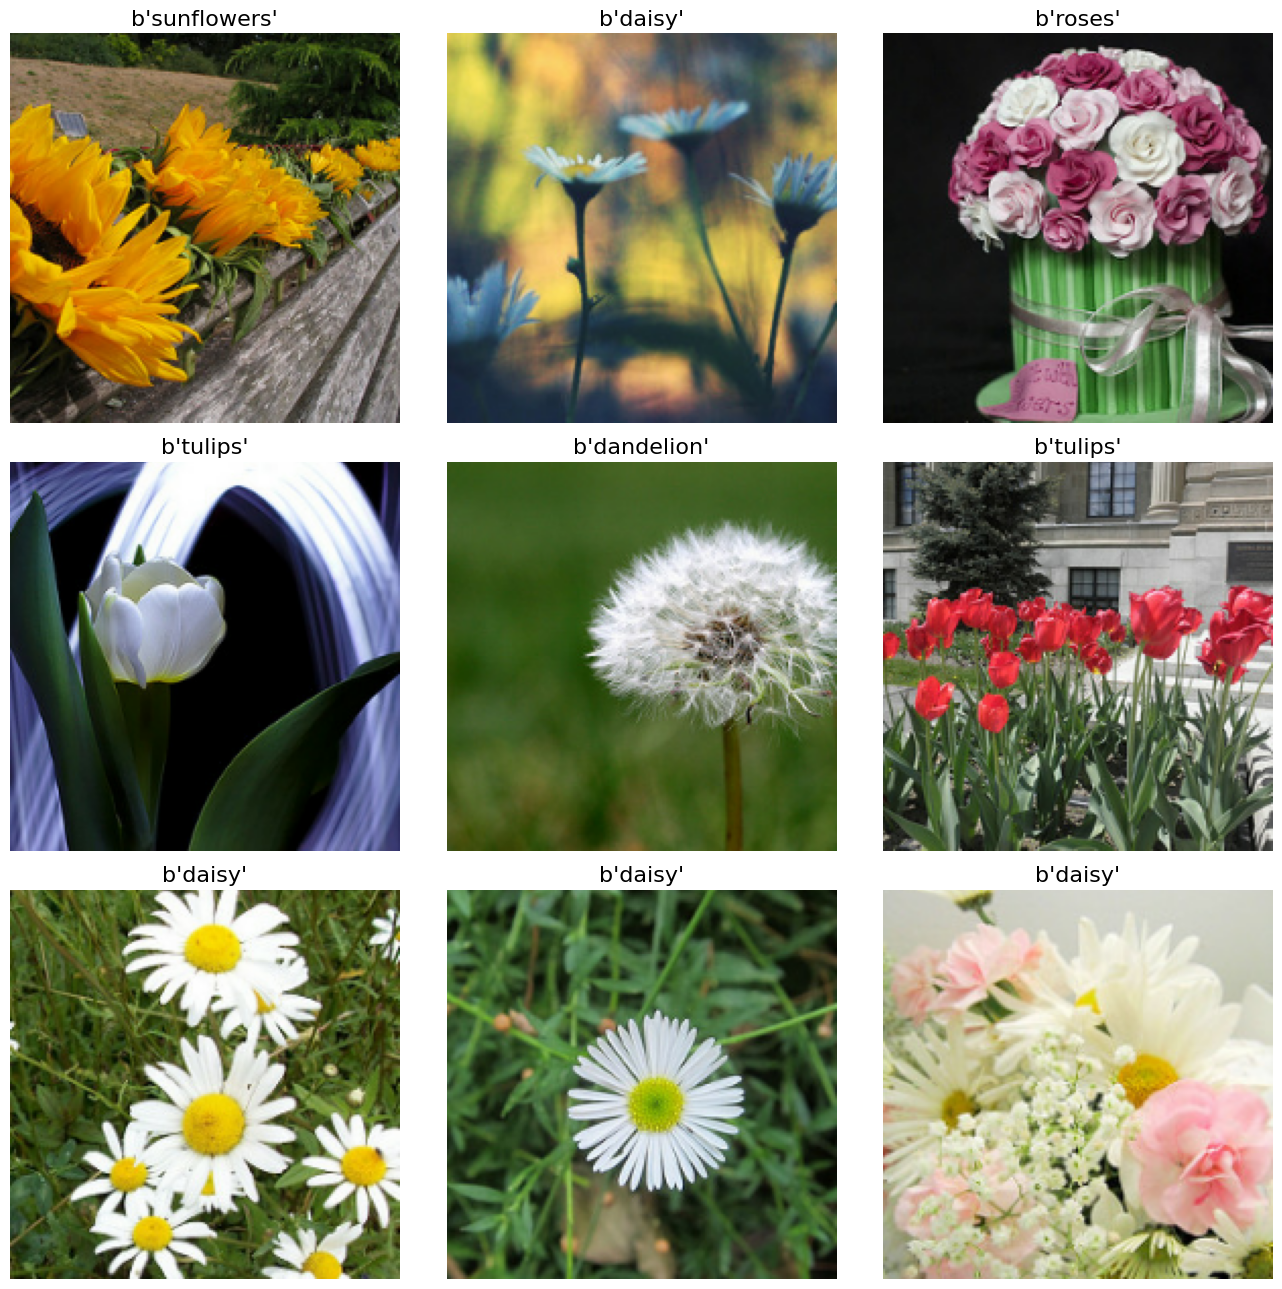

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['sunflowers', 'sunflowers', 'tulips', 'roses', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'roses', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['tulips', 'dandelion', 'daisy', 'dandelion', 'dandelion', 'roses', 'roses', 'roses', 'sunflowers', 'roses'])
Image batch shape (10, 192, 192, 3), ['tulips', 'daisy', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'daisy', 'daisy'])
Image batch shape (10, 192, 192, 3), ['daisy', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'daisy', 'tulips'])
Image batch shape (10, 192, 192, 3), ['roses', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'roses', 'roses', 'daisy', 'roses', 'tulips'])
Image batch shape (10, 192, 192, 3), ['daisy', 'tulips', 'sunflowers', 'daisy', 'roses', 'tulips', 'roses', 'dandelion', 'dandelion', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'roses', 'sunflowers', 'tulips', 'tulips', 'sunfl

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [ ]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['daisy', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'daisy', 'daisy', 'sunflowers', 'tulips', 'sunflowers'])
Image batch shape (10,), ['sunflowers', 'roses', 'roses', 'dandelion', 'dandelion', 'daisy', 'tulips', 'dandelion', 'tulips', 'daisy'])
Image batch shape (10,), ['dandelion', 'tulips', 'roses', 'daisy', 'sunflowers', 'dandelion', 'daisy', 'tulips', 'tulips', 'sunflowers'])
Image batch shape (10,), ['daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'dandelion', 'tulips', 'sunflowers'])
Image batch shape (10,), ['dandelion', 'roses', 'sunflowers', 'tulips', 'tulips', 'tulips', 'dandelion', 'daisy', 'daisy', 'daisy'])
Image batch shape (10,), ['dandelion', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'dandelion', 'tulips', 'tulips', 'daisy'])
Image batch shape (10,), ['dandelion', 'daisy', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'roses', 'sunflowers', 'roses', 'dandelion'])
Image batch shape (

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
# GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['1', '0', '3', '2', '4', '3', '0', '2', '3', '2'])
Image batch shape (10, 192, 192, 3), ['2', '4', '2', '4', '3', '3', '4', '2', '3', '0'])
Image batch shape (10, 192, 192, 3), ['0', '2', '4', '1', '4', '4', '4', '0', '0', '4'])
Image batch shape (10, 192, 192, 3), ['3', '1', '1', '1', '1', '2', '0', '3', '1', '2'])
Image batch shape (10, 192, 192, 3), ['2', '2', '2', '3', '3', '1', '4', '2', '0', '2'])
Image batch shape (10, 192, 192, 3), ['4', '3', '4', '1', '0', '0', '2', '2', '2', '3'])
Image batch shape (10, 192, 192, 3), ['4', '2', '1', '4', '2', '3', '0', '3', '1', '2'])
Image batch shape (10, 192, 192, 3), ['1', '4', '1', '0', '3', '3', '1', '0', '0', '1'])
Image batch shape (10, 192, 192, 3), ['3', '4', '1', '1', '3', '3', '1', '4', '3', '4'])
Image batch shape (10, 192, 192, 3), ['1', '1', '3', '4', '4', '3', '3', '1', '3', '3'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument).

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames.

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests.

iv) Then **use the functions from above** to write the TFRecord files.

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files.


In [ ]:
# i) Adapt following functions to Spark.
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return (image, label2)

def resize_and_crop_image_rdd(tuple_image_label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    image, label = tuple_image_label # unpack image and label
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image_rdd(tuple_image_label):
    # this reduces the amount of data, but takes some time
    image, label = tuple_image_label # unpack image and label
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

# ii) Replace the TensorFolw Dataset objects with RDDs, starting with an RDD that contains the list of image filenames.
dsetFilesRDD = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN)) # Convert the list of file URLs into an RDD

# iii) Sample the RDD to a smaller number with sampling factor = 0.02
dsetFilesRDD_sample = dsetFilesRDD.sample(withReplacement=False, fraction=0.02)

In [ ]:
# iv) Using the functions from above to write the TFRecord files on sample RDD
dsetDecodedRDD_sample = dsetFilesRDD_sample.map(decode_jpeg_and_label)
dsetResizedRDD_sample = dsetDecodedRDD_sample.map(resize_and_crop_image_rdd)
dsetRecompressRDD_sample = dsetResizedRDD_sample.map(recompress_image_rdd)

## Write the TFRecord files with sample RDD
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/TASK1/flowers' # setting output folder

# Function to write TFRecord files for each partition
def write_partition(partition_index, iterator):
    partition_size = 0
    filenames = []
    # filename with partition index and partition size
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(filename) as out_file:
        for image, label in iterator:
            partition_size += 1
            example = to_tfrecord(out_file, image.numpy(), label.numpy())
            out_file.write(example.SerializeToString())

    filenames.append(filename)
    print(f"Wrote file {filename} containing {partition_size} records")
    return filenames

dsetRecompressRDD_sample.mapPartitionsWithIndex(write_partition).collect()

['gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers00.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers01.tfrec']

In [ ]:
# v) The function for writing to the TFRecord files

### copy from above
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
### copy from above

# write the images to files in RDD.
# def write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT): # original code
def write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT,PARTITIONS): ### TASK 1d ###
    print("Writing TFRecords")
    tt0 = time.time()

    # dsetFilesRDD = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN)) # original code
    dsetFilesRDD = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN), PARTITIONS) ### TASK 1d ###
    dsetDecodedRDD = dsetFilesRDD.map(decode_jpeg_and_label)
    dsetResizedRDD = dsetDecodedRDD.map(resize_and_crop_image_rdd)
    dsetRecompressRDD = dsetResizedRDD.map(recompress_image_rdd)

    # apply write_partiton on each partition
    filenames = dsetRecompressRDD.mapPartitionsWithIndex(write_partition).collect()

    print("Total time: "+str(time.time()-tt0))

    return filenames

# apply write_tfrecord function
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/TASK1/flowers' # setting output folder

PARTITIONS = 16 # no of partitions ### TASK 1d ###

# filenames = write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT) # original code
filenames = write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT,PARTITIONS) ### TASK 1d ###
filenames

Writing TFRecords
Total time: 169.67125582695007


['gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers00.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers01.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers02.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers03.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers04.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers05.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers06.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers07.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers08.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers09.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers10.tfrec',
 'gs://bigdata-cw24-230048952-storage/tfrec

### 1b)	Testing
i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


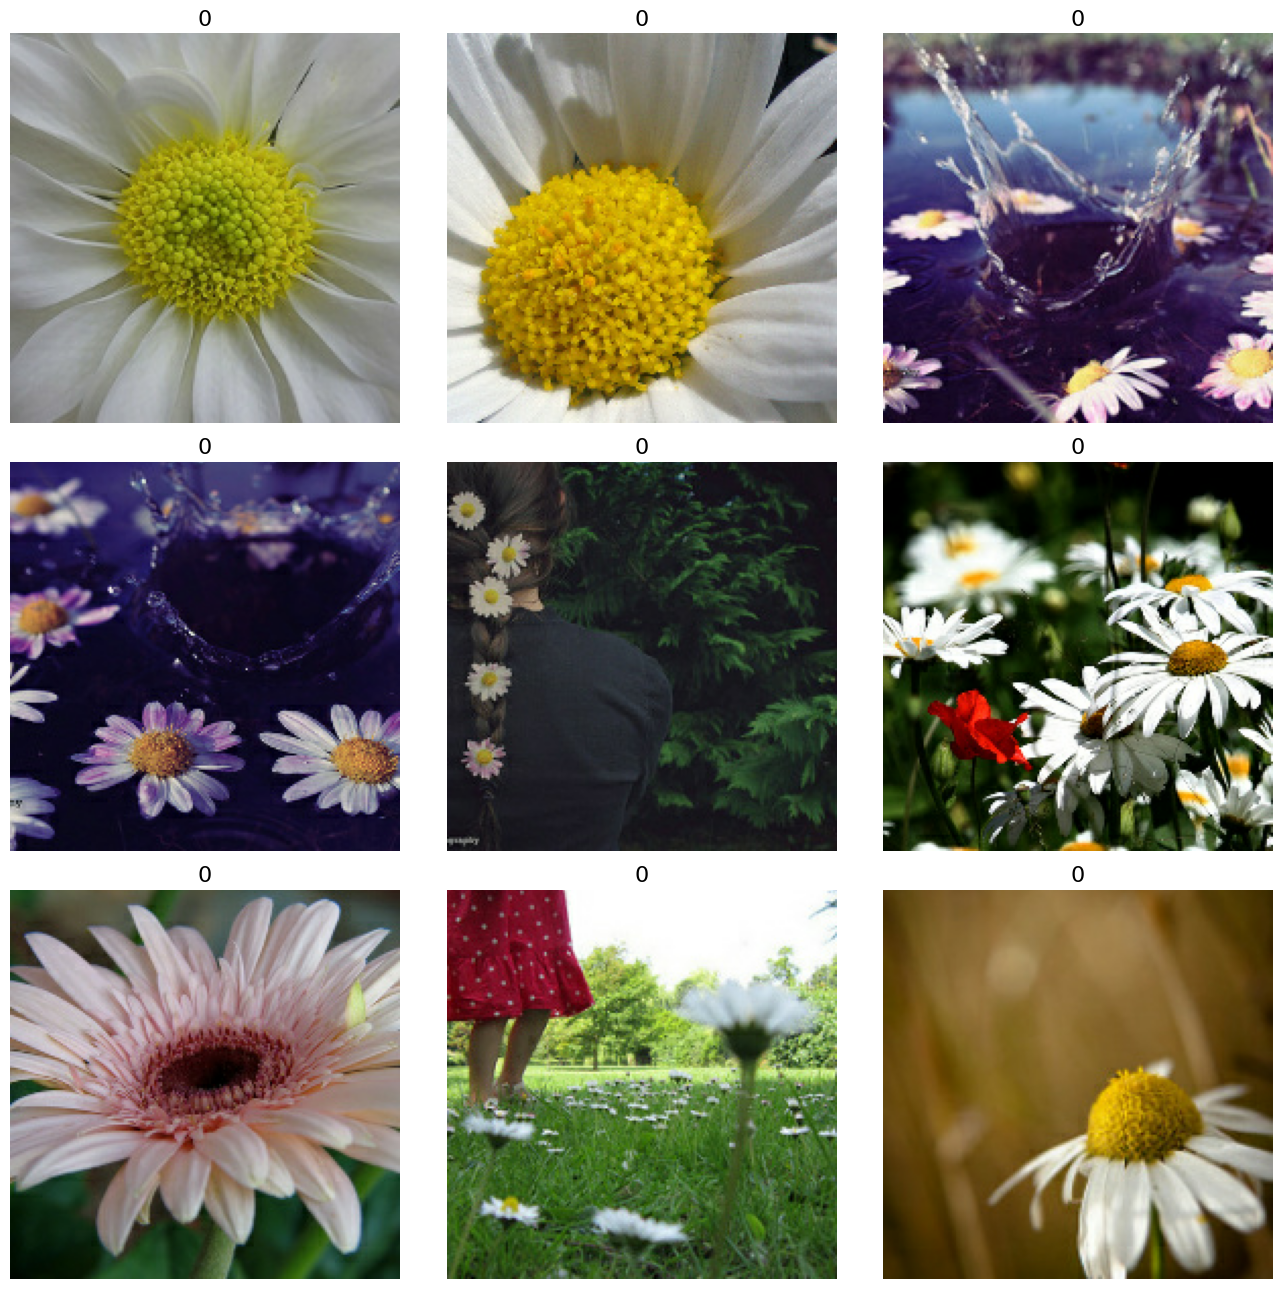

In [ ]:
datasetTfrec_rdd = load_dataset(filenames)
display_9_images_from_dataset(datasetTfrec_rdd)

ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
%cd /content/drive/My Drive/BD-CW

/content/drive/My Drive/BD-CW


In [ ]:
%%writefile spark_write_tfrec.py
import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
# import findspark
# findspark.init()
import pyspark
print("PySpark version " + pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

# i) Adapt following functions to Spark.
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return (image, label2)

def resize_and_crop_image_rdd(tuple_image_label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    image, label = tuple_image_label # unpack image and label
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image_rdd(tuple_image_label):
    # this reduces the amount of data, but takes some time
    image, label = tuple_image_label # unpack image and label
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

# Function to write TFRecord files for each partition
def write_partition(partition_index, iterator):
    partition_size = 0
    filenames = []
    # filename with partition index and partition size
    filename = GCS_OUTPUT + "{:02d}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(filename) as out_file:
        for image, label in iterator:
            partition_size += 1
            example = to_tfrecord(out_file, image.numpy(), label.numpy())
            out_file.write(example.SerializeToString())

    filenames.append(filename)
    print(f"Wrote file {filename} containing {partition_size} records")
    return filenames

# v) The function for writing to the TFRecord files

### copy from above
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
### copy from above

# write the images to files in RDD.
# def write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT): # original code
def write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT,PARTITIONS): ### TASK 1d ###
    print("Writing TFRecords")
    tt0 = time.time()

    # dsetFilesRDD = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN)) # original code
    dsetFilesRDD = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN), PARTITIONS) ### TASK 1d ###
    dsetDecodedRDD = dsetFilesRDD.map(decode_jpeg_and_label)
    dsetResizedRDD = dsetDecodedRDD.map(resize_and_crop_image_rdd)
    dsetRecompressRDD = dsetResizedRDD.map(recompress_image_rdd)

    # apply write_partiton on each partition
    filenames = dsetRecompressRDD.mapPartitionsWithIndex(write_partition).collect()

    print("Total time: "+str(time.time()-tt0))

    return filenames

# apply write_tfrecord function
# Setting the GSC_PATTERN, PARTITIONS, GCS_OUTPUT and run the function
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data
PROJECT = 'bigdata-cw24-230048952'
BUCKET = 'gs://{}-storage'.format(PROJECT)

GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/TASK1/flowers' # setting output folder
PARTITIONS = 16 # no of partitions ### TASK 1d ###

# filenames = write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT) # original code
filenames = write_tfrecords_rdd(GCS_PATTERN,GCS_OUTPUT,PARTITIONS) ### TASK 1d ###
print(filenames)

Overwriting spark_write_tfrec.py


In [ ]:
# run the file locally in Spark
%run spark_write_tfrec.py

Tensorflow version 2.15.0
PySpark version 3.5.0
<SparkContext master=local[*] appName=pyspark-shell>
Writing TFRecords
Total time: 157.798269033432
['gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers00.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers01.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers02.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers03.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers04.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers05.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers06.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers07.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers08.tfrec', 'gs://bigdata-cw24-230048952-storage/tfrecords-jpeg-192x192-2/TASK1/flowers09

<Figure size 640x480 with 0 Axes>

### 1c) Set up a cluster and run the script.

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output.


In [ ]:
# Setting the zone of google cloud "us-central1-a,b,c,d" if needed
!gcloud config set compute/zone us-central1-c

Updated property [compute/zone].


In [ ]:
# Set up a CLUSTER with single machine, 100 SSD, and 8 vCPUs
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/accc4296-a091-36ba-a4ce-c1627dabf71e].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster] Cluster placed in zone [us-central1-c].


Run the script in the cloud and test the output.

In [ ]:
# Run the script in cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./spark_write_tfrec.py

Job [b5b8ea1e518c48e1b5077c6052ae4e20] submitted.
Waiting for job output...
2024-04-30 11:53:00.117988: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-30 11:53:00.118039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
PySpark version 2.4.8
24/04/30 11:53:03 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/30 11:53:03 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/30 11:53:03 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/30 11:53:03 INFO org.spark_project.jetty.util.log: Logging initialized @5816ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/30 11:53:03 INFO org.spark_project.jetty.server.Server: jetty

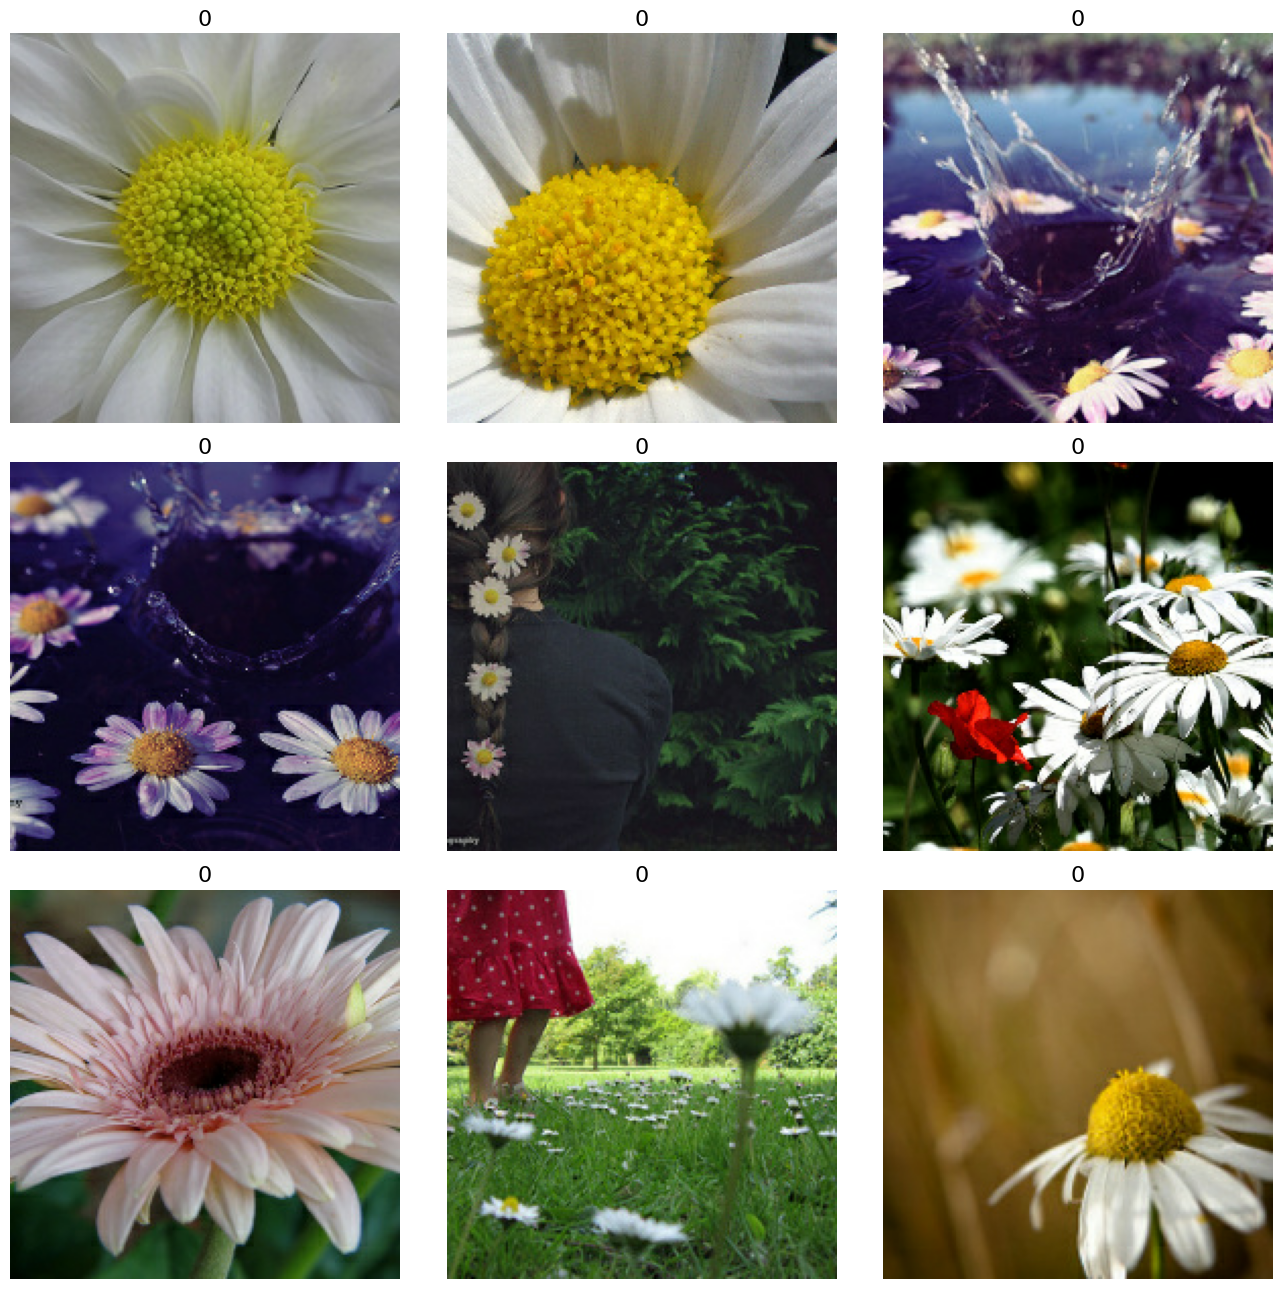

In [ ]:
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec_rdd = load_dataset(filenames)
display_9_images_from_dataset(datasetTfrec_rdd)

In [ ]:
# Delete the cluster to free the machine
!gcloud dataproc clusters delete bigdata-cw24-230048952-cluster --region=us-central1

The cluster 'bigdata-cw24-230048952-cluster' and all attached disks will be 
deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/04e04a66-5159-37e7-9a39-67bfba28c945].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster].


In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script.

In [ ]:
# a cluster with 1 master and 7 worker nodes. 1vCPU for each.
# setting the maximise standard disk for each worker
vCPU = 1
worker = 7
worker_disk = 2000 // worker

# set up the cluster
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-$vCPU \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s \
    --num-workers $worker \
    --worker-machine-type n1-standard-$vCPU \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size $worker_disk \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/5fc97bcd-1873-3517-9c75-9d1ab853b045].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
# Run the script
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./spark_write_tfrec.py

Job [59cdd4cf87bb46a2a4f79bb4fc182021] submitted.
Waiting for job output...
2024-04-30 12:07:00.489383: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-30 12:07:00.489924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
PySpark version 2.4.8
24/04/30 12:07:05 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/30 12:07:05 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/30 12:07:06 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/30 12:07:06 INFO org.spark_project.jetty.util.log: Logging initialized @10571ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/30 12:07:06 INFO org.spark_project.jetty.server.Server: jett

### 1d)	Optimisation, experiments, and discussion

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**.

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud.

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here?

Write the code below and your answers in the report.


In [ ]:
# i) improve parallelisation with partition increase to 16 and run in the 8 VMs
# Run the script
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./spark_write_tfrec.py

Job [3e6809c78e2243ada1dfdcb9343589a4] submitted.
Waiting for job output...
2024-04-30 12:13:33.271804: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-30 12:13:33.271989: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
PySpark version 2.4.8
24/04/30 12:13:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/30 12:13:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/30 12:13:37 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/30 12:13:37 INFO org.spark_project.jetty.util.log: Logging initialized @7574ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/30 12:13:37 INFO org.spark_project.jetty.server.Server: jetty

In [ ]:
# Delete the cluster
!gcloud dataproc clusters delete bigdata-cw24-230048952-cluster --region=us-central1

The cluster 'bigdata-cw24-230048952-cluster' and all attached disks will be 
deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/5d51a8e6-f982-31fc-97ad-2cb0e6589df4].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster].


In [ ]:
# ii) 4 machines with double the resources
# a cluster with 1 master and 3 worker nodes. 2vCPU for each.
# setting the maximise standard disk for each worker
vCPU = 2
worker = 3
worker_disk = 2000 // worker

# set up the cluster
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-$vCPU \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s \
    --num-workers $worker \
    --worker-machine-type n1-standard-$vCPU \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size $worker_disk \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/de875962-19a0-3151-a1c1-540964f667ea].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
# Run the script
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./spark_write_tfrec.py

Job [17ffe3684db44dd6a04194feb9653ecb] submitted.
Waiting for job output...
2024-04-30 12:24:30.331271: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-30 12:24:30.331314: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
PySpark version 2.4.8
24/04/30 12:24:34 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/30 12:24:34 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/30 12:24:34 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/30 12:24:34 INFO org.spark_project.jetty.util.log: Logging initialized @7053ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/30 12:24:34 INFO org.spark_project.jetty.server.Server: jetty

In [ ]:
# Delete the cluster
!gcloud dataproc clusters delete bigdata-cw24-230048952-cluster --region=us-central1

The cluster 'bigdata-cw24-230048952-cluster' and all attached disks will be 
deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/c9ce8842-260f-311d-90c4-d9474dbce5de].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster].


In [ ]:
# ii) Set up a CLUSTER of 1 machine with eightfold resources
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/30ba7e54-855c-3ee5-aee3-acad57bdf81b].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
# Run the script in cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./spark_write_tfrec.py

Job [cffeb48f543543b188f4621f98dbca96] submitted.
Waiting for job output...
2024-04-30 12:36:16.026636: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-30 12:36:16.026678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
PySpark version 2.4.8
24/04/30 12:36:19 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/30 12:36:19 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/30 12:36:19 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/30 12:36:19 INFO org.spark_project.jetty.util.log: Logging initialized @5812ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/30 12:36:19 INFO org.spark_project.jetty.server.Server: jetty

In [ ]:
# Delete the cluster
!gcloud dataproc clusters delete bigdata-cw24-230048952-cluster --region=us-central1

The cluster 'bigdata-cw24-230048952-cluster' and all attached disks will be 
deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/e91f3008-bdbe-3a92-b91d-8368125d6eec].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster].


# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'daisy'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'daisy'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image bat

## Task 2: Parallelising the speed test with Spark in the cloud.

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average.
*   vi) write the results to a pickle file in your bucket
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py`


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
# i) the functions to create a dataset and create a list of parameter combinations in an RDD

### copy from Section 1 ###
# read and process image data
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

# read the tfrecord from public bucket
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset
### copy from Section 1 ###

# Setting the TARGET_SIZE, CLASSES, GCS_PATTERN, GCS_OUTPUT and run the functions
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'

## function to create TensorFlow dataset
def create_TensorFlow_dataset(GCS_PATTERN):
    dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
    dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
    dsetResized = dsetDecoded.map(resize_and_crop_image)
    dataset4 = dsetResized.map(recompress_image)

    return dataset4

## function to read from TFRecord files and load the dataset
def create_TFRecord_dataset(GCS_OUTPUT):
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetTfrec = load_dataset(tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec"))

    return datasetTfrec

## create a list of parameter combinations in an RDD
def parameter_combinations_rdd(batch_sizes, batch_numbers, repetitions):

    paramsRDD = sc.parallelize([(bs, ds, rep) for bs in batch_sizes for ds in batch_numbers
                                for rep in repetitions], 8)
    return paramsRDD

In [ ]:
# ii) run timing test for each combination in parallel

# the function to run timing test in image files
def img_time_configs(params):
    with open("/dev/null", mode='w') as null_file:  # for printing the output without showing it
        tt = time.time()  # for overall time taking
        bs, ds, rep = params # unpack parameters
        dataset = create_TensorFlow_dataset(GCS_PATTERN) # create the image dataset
        batched_dataset = dataset.batch(bs)
        timing_set = batched_dataset.take(ds)
        print("bs: {}, ds: {}, rep: {}".format(bs, ds, rep))
        t0 = time.time()
        for image, label in timing_set:
            # Process each batch of images
            print("Image batch shape {}, {})".format(image.shape,
                    [str(lbl) for lbl in label.numpy()]), null_file)
        td = time.time() - t0  # duration for processing images
        result = ((bs * ds) / td)
    print("total time: " + str(time.time() - tt))
    return params, result

# the function to run timing test in .tfrec files
def tf_time_configs(params):
    with open("/dev/null", mode='w') as null_file:  # for printing the output without showing it
        tt = time.time()  # for overall time taking
        bs, ds, rep = params # unpack parameters
        datasetTfrec = load_dataset(tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")) # reading .tfrec dataset
        batched_dataset = datasetTfrec.batch(bs)
        timing_set = batched_dataset.take(ds)
        print("bs: {}, ds: {}, rep: {}".format(bs, ds, rep))
        t0 = time.time()
        for image, label in timing_set:
            # Process each batch of images
            print("Image batch shape {}, {})".format(image.shape,
                    [str(lbl) for lbl in label.numpy()]), null_file)
        td = time.time() - t0  # duration for processing images
        result = ((bs * ds) / td)
    print("total time: " + str(time.time() - tt))
    return params, result

# Create the parameter combinations RDD and run both functions above
batch_sizes = [2, 4]
batch_numbers = [3, 6]
repetitions = [1]

paramsRDD = parameter_combinations_rdd(batch_sizes, batch_numbers, repetitions)
paramsRDD.cache() ### TASK 2c ###
img_resultRDD = paramsRDD.map(img_time_configs).cache() ### TASK 2c ###
tf_resultRDD = paramsRDD.map(tf_time_configs).cache() ### TASK 2c ###

# iii) save RDDs in array ### TASK 2c ###
### after applying caching in RDD, no need to stroe the result here, will block in script ###
img_ParamsResults_array = img_resultRDD.collect()
tf_ParamsResults_array = tf_resultRDD.collect()

In [ ]:
# iv) create RDDs with all results for each parameter with its results

### TASK 2c ###
### after applying caching in RDD, no need to stroe and retrive the result here, will block in script ###
img_resultRDD = sc.parallelize(img_ParamsResults_array)
tf_resultRDD = sc.parallelize(tf_ParamsResults_array)

# for image files ### TASK 2c ###
img_bsRDD = img_resultRDD.map(lambda x: (x[0][0], x[1])).cache() # batch_sizes
img_dsRDD = img_resultRDD.map(lambda x: (x[0][1], x[1])).cache() # batch_numbers
img_repRDD = img_resultRDD.map(lambda x: (x[0][2], x[1])).cache() # repetitions
img_sizeRDD = img_resultRDD.map(lambda x: (x[0][0] * x[0][1], x[1])).cache() # batch_size x batch_number

# for tfrec files ### TASK 2c ###
tf_bsRDD = tf_resultRDD.map(lambda x: (x[0][0], x[1])).cache() # batch_sizes
tf_dsRDD = tf_resultRDD.map(lambda x: (x[0][1], x[1])).cache() # batch_numbers
tf_repRDD = tf_resultRDD.map(lambda x: (x[0][2], x[1])).cache() # repetitions
tf_sizeRDD = tf_resultRDD.map(lambda x: (x[0][0] * x[0][1], x[1])).cache() # batch_size x batch_number

In [ ]:
# v) create RDDs with the average reading speeds for each parameter value

# add 1 in each elements, (param, result) -> (param, (result, 1))
def count_element(pr):
    return (pr[0], (pr[1], 1))

# add reading speeds and count for each parameter value, (param, (sum(result), count))
def add(rc1, rc2):
    return ((rc1[0] + rc2[0], rc1[1] + rc2[1]))

# average for each count, (param, (sum(result), count)) -> (param, sum(result)/count)
def avg(p_rc):
    return (p_rc[0], p_rc[1][0]/p_rc[1][1])

# for image files
img_bsRDD_avg = img_bsRDD.map(count_element).reduceByKey(add).map(avg)
img_dsRDD_avg = img_dsRDD.map(count_element).reduceByKey(add).map(avg)
img_repRDD_avg = img_repRDD.map(count_element).reduceByKey(add).map(avg)
img_sizeRDD_avg = img_sizeRDD.map(count_element).reduceByKey(add).map(avg)

# for tfrec files
tf_bsRDD_avg = tf_bsRDD.map(count_element).reduceByKey(add).map(avg)
tf_dsRDD_avg = tf_dsRDD.map(count_element).reduceByKey(add).map(avg)
tf_repRDD_avg = tf_repRDD.map(count_element).reduceByKey(add).map(avg)
tf_sizeRDD_avg = tf_sizeRDD.map(count_element).reduceByKey(add).map(avg)

In [ ]:
# vi) write the results to a pickle file in your bucket
import argparse
import subprocess

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))

    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runResults(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    results = {
        'img_bs_raw': img_bsRDD.collect(), 'img_ds_raw': img_dsRDD.collect(),
        'img_rep_raw': img_repRDD.collect(), 'img_size_raw': img_sizeRDD.collect(),
        'tf_bs_raw': tf_bsRDD.collect(), 'tf_ds_raw': tf_dsRDD.collect(),
        'tf_rep_raw': tf_repRDD.collect(), 'tf_size_raw': tf_sizeRDD.collect(),
        'img_bs_avg': img_bsRDD_avg.collect(), 'img_ds_avg': img_dsRDD_avg.collect(),
        'img_rep_avg': img_repRDD_avg.collect(), 'img_size_avg': img_sizeRDD_avg.collect(),
        'tf_bs_avg': tf_bsRDD_avg.collect(), 'tf_ds_avg': tf_dsRDD_avg.collect(),
        'tf_rep_avg': tf_repRDD_avg.collect(), 'tf_size_avg': tf_sizeRDD_avg.collect()
        }
    save(results, args.out_bucket, args.out_file)

PROJECT = 'bigdata-cw24-230048952'
BUCKET = 'gs://{}-storage'.format(PROJECT)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab
    runResults(sys.argv[1:])
elif __name__ == "__main__" : # but define them manually
    runResults(["--out_bucket", BUCKET, "--out_file", "results.pkl"])

['--out_bucket', 'gs://bigdata-cw24-230048952-storage', '--out_file', 'results.pkl']
Saving results.pkl to gs://bigdata-cw24-230048952-storage
gstuil returned: 0
b'Copying file://results.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  914.0 B]                                                \r-\r- [0 files][  914.0 B/  914.0 B]                                                \r- [1 files][  914.0 B/  914.0 B]                                                \r\\\r\nOperation completed over 1 objects/914.0 B.                                      \n'


In [ ]:
%cd /content/drive/My Drive/BD-CW

/content/drive/My Drive/BD-CW


In [ ]:
# vii) Write your code it into a file using the cell magic %%writefile spark_job.py
%%writefile spark_job.py
import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
# import findspark
# findspark.init()
import pyspark
print("PySpark version " + pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

# i) the functions to create a dataset and create a list of parameter combinations in an RDD

### copy from Section 1 ###
# read and process image data
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

# read the tfrecord from public bucket
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset
### copy from Section 1 ###

# Setting the TARGET_SIZE, CLASSES, GCS_PATTERN, GCS_OUTPUT and run the functions
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'

## function to create TensorFlow dataset
def create_TensorFlow_dataset(GCS_PATTERN):
    dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
    dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
    dsetResized = dsetDecoded.map(resize_and_crop_image)
    dataset4 = dsetResized.map(recompress_image)

    return dataset4

## function to read from TFRecord files and load the dataset
def create_TFRecord_dataset(GCS_OUTPUT):
    filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
    datasetTfrec = load_dataset(tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec"))

    return datasetTfrec

## create a list of parameter combinations in an RDD
def parameter_combinations_rdd(batch_sizes, batch_numbers, repetitions):

    paramsRDD = sc.parallelize([(bs, ds, rep) for bs in batch_sizes for ds in batch_numbers
                                for rep in repetitions], 8)
    return paramsRDD

# ii) run timing test for each combination in parallel

# the function to run timing test in image files
def img_time_configs(params):
    with open("/dev/null", mode='w') as null_file:  # for printing the output without showing it
        tt = time.time()  # for overall time taking
        bs, ds, rep = params # unpack parameters
        dataset = create_TensorFlow_dataset(GCS_PATTERN)
        batched_dataset = dataset.batch(bs)
        timing_set = batched_dataset.take(ds)
        print("bs: {}, ds: {}, rep: {}".format(bs, ds, rep))
        t0 = time.time()
        for image, label in timing_set:
            # Process each batch of images
            print("Image batch shape {}, {})".format(image.shape,
                    [str(lbl) for lbl in label.numpy()]), null_file)
        td = time.time() - t0  # duration for processing images
        result = ((bs * ds) / td)
    print("total time: " + str(time.time() - tt))
    return params, result

# the function to run timing test in .tfrec files
def tf_time_configs(params):
    with open("/dev/null", mode='w') as null_file:  # for printing the output without showing it
        tt = time.time()  # for overall time taking
        bs, ds, rep = params # unpack parameters
        datasetTfrec = load_dataset(tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec"))
        batched_dataset = datasetTfrec.batch(bs)
        timing_set = batched_dataset.take(ds)
        print("bs: {}, ds: {}, rep: {}".format(bs, ds, rep))
        t0 = time.time()
        for image, label in timing_set:
            # Process each batch of images
            print("Image batch shape {}, {})".format(image.shape,
                    [str(lbl) for lbl in label.numpy()]), null_file)
        td = time.time() - t0  # duration for processing images
        result = ((bs * ds) / td)
    print("total time: " + str(time.time() - tt))
    return params, result

# Create the parameter combinations RDD and run both functions above

## small example for testing
# batch_sizes = [2, 4, 6, 8]
# batch_numbers = [3, 6, 9, 12]
# repetitions = [1, 2]

batch_sizes = [2, 4, 6, 8, 10, 12, 14, 16]
batch_numbers = [3, 6, 9, 12, 15, 18, 21, 24]
repetitions = [1, 2, 3, 4]

paramsRDD = parameter_combinations_rdd(batch_sizes, batch_numbers, repetitions)
paramsRDD.cache() ### TASK 2c ###
img_resultRDD = paramsRDD.map(img_time_configs).cache() ### TASK 2c ###
tf_resultRDD = paramsRDD.map(tf_time_configs).cache() ### TASK 2c ###

# iii) save RDDs in array ### Applying caching in RDD, no need to stroe the result here ###
# img_ParamsResults_array = img_resultRDD.collect()
# tf_ParamsResults_array = tf_resultRDD.collect()

# iv) create RDDs with all results for each parameter with its results

### Applying caching in RDD, no need to stroe and retrive the result here ###
# img_resultRDD = sc.parallelize(img_ParamsResults_array)
# tf_resultRDD = sc.parallelize(tf_ParamsResults_array)

# for image files ### TASK 2c ###
img_bsRDD = img_resultRDD.map(lambda x: (x[0][0], x[1])).cache() # batch_sizes
img_dsRDD = img_resultRDD.map(lambda x: (x[0][1], x[1])).cache() # batch_numbers
img_repRDD = img_resultRDD.map(lambda x: (x[0][2], x[1])).cache() # repetitions
img_sizeRDD = img_resultRDD.map(lambda x: (x[0][0] * x[0][1], x[1])).cache() # batch_size x batch_number

# for tfrec files ### TASK 2c ###
tf_bsRDD = tf_resultRDD.map(lambda x: (x[0][0], x[1])).cache() # batch_sizes
tf_dsRDD = tf_resultRDD.map(lambda x: (x[0][1], x[1])).cache() # batch_numbers
tf_repRDD = tf_resultRDD.map(lambda x: (x[0][2], x[1])).cache() # repetitions
tf_sizeRDD = tf_resultRDD.map(lambda x: (x[0][0] * x[0][1], x[1])).cache() # batch_size x batch_number

# v) create RDDs with the average reading speeds for each parameter value

# add 1 in each elements, (param, result) -> (param, (result, 1))
def count_element(pr):
    return (pr[0], (pr[1], 1))

# add reading speeds and count for each parameter value, (param, (sum(result), count))
def add(rc1, rc2):
    return ((rc1[0] + rc2[0], rc1[1] + rc2[1]))

# average for each count, (param, (sum(result), count)) -> (param, sum(result)/count)
def avg(p_rc):
    return (p_rc[0], p_rc[1][0]/p_rc[1][1])

# for image files
img_bsRDD_avg = img_bsRDD.map(count_element).reduceByKey(add).map(avg)
img_dsRDD_avg = img_dsRDD.map(count_element).reduceByKey(add).map(avg)
img_repRDD_avg = img_repRDD.map(count_element).reduceByKey(add).map(avg)
img_sizeRDD_avg = img_sizeRDD.map(count_element).reduceByKey(add).map(avg)

# for tfrec files
tf_bsRDD_avg = tf_bsRDD.map(count_element).reduceByKey(add).map(avg)
tf_dsRDD_avg = tf_dsRDD.map(count_element).reduceByKey(add).map(avg)
tf_repRDD_avg = tf_repRDD.map(count_element).reduceByKey(add).map(avg)
tf_sizeRDD_avg = tf_sizeRDD.map(count_element).reduceByKey(add).map(avg)

# vi) write the results to a pickle file in your bucket
import argparse
import subprocess

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))

    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runResults(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    results = {
        'img_bs_raw': img_bsRDD.collect(), 'img_ds_raw': img_dsRDD.collect(),
        'img_rep_raw': img_repRDD.collect(), 'img_size_raw': img_sizeRDD.collect(),
        'tf_bs_raw': tf_bsRDD.collect(), 'tf_ds_raw': tf_dsRDD.collect(),
        'tf_rep_raw': tf_repRDD.collect(), 'tf_size_raw': tf_sizeRDD.collect(),
        'img_bs_avg': img_bsRDD_avg.collect(), 'img_ds_avg': img_dsRDD_avg.collect(),
        'img_rep_avg': img_repRDD_avg.collect(), 'img_size_avg': img_sizeRDD_avg.collect(),
        'tf_bs_avg': tf_bsRDD_avg.collect(), 'tf_ds_avg': tf_dsRDD_avg.collect(),
        'tf_rep_avg': tf_repRDD_avg.collect(), 'tf_size_avg': tf_sizeRDD_avg.collect()
        }
    save(results, args.out_bucket, args.out_file)

PROJECT = 'bigdata-cw24-230048952'
BUCKET = 'gs://{}-storage'.format(PROJECT)

time_string = str(datetime.datetime.now().strftime("%y%m%d-%H%M"))

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab
    runResults(sys.argv[1:])
elif __name__ == "__main__" : # but define them manually
    runResults(["--out_bucket", BUCKET, "--out_file", "results_{}.pkl".format(time_string)])

Overwriting spark_job.py


### 2b) Testing the code and collecting results

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
%run spark_job.py

Tensorflow version 2.15.0
PySpark version 3.5.0
<SparkContext master=local[*] appName=pyspark-shell>
['--out_bucket', 'gs://bigdata-cw24-230048952-storage', '--out_file', 'results_240428-0855.pkl']
Saving results_240428-0855.pkl to gs://bigdata-cw24-230048952-storage
gstuil returned: 0
b'Copying file://results_240428-0855.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  4.0 KiB]                                                \r/ [1 files][  4.0 KiB/  4.0 KiB]                                                \r\nOperation completed over 1 objects/4.0 KiB.                                      \n'


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
# Setting the zone of google cloud "us-central1-a,b,c,d" if needed
!gcloud config set compute/zone us-central1-c

Updated property [compute/zone].


In [ ]:
# Set up a CLUSTER with single machine, 100 SSD, and 8 vCPUs
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/7b00d2cc-3438-3dfe-b8b0-a653507d86df].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
# Run the script in cluster
PROJECT = 'bigdata-cw24-230048952'
BUCKET = 'gs://{}-storage'.format(PROJECT)

time_string = str(datetime.datetime.now().strftime("%y%m%d-%H%M"))
FILENAME = "result_{}.pkl".format(time_string)

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./spark_job.py \
    -- --out_bucket $BUCKET --out_file $FILENAME

Job [3c9fa49b9bf3495eb6168594a614aafa] submitted.
Waiting for job output...
2024-04-30 16:01:58.418093: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-30 16:01:58.418138: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
PySpark version 2.4.8
24/04/30 16:02:01 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/30 16:02:01 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/30 16:02:01 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/30 16:02:01 INFO org.spark_project.jetty.util.log: Logging initialized @4618ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/30 16:02:01 INFO org.spark_project.jetty.server.Server: jetty

In [ ]:
# Delete the cluster
!gcloud dataproc clusters delete bigdata-cw24-230048952-cluster --region=us-central1

The cluster 'bigdata-cw24-230048952-cluster' and all attached disks will be 
deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/bigdata-cw24-230048952/regions/us-central1/operations/9f0c4d09-a99c-3958-a0ed-2a2e9f436b56].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-cw24-230048952/regions/us-central1/clusters/bigdata-cw24-230048952-cluster].


### 2c) Improve efficiency

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

### 2d) Retrieve, analyse and discuss the output

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

In [ ]:
# load the results from bucket
PROJECT = 'bigdata-cw24-230048952'
BUCKET = 'gs://{}-storage'.format(PROJECT)
FILENAME = "result_240430-1601.pkl"

%cd /content/drive/MyDrive/BD-CW
!gsutil cp $BUCKET/$FILENAME .
# !ls -l
with open(FILENAME,mode='rb') as f:
    results = pickle.load(f)

results.keys()

/content/drive/My Drive/BD-CW
Copying gs://bigdata-cw24-230048952-storage/result_240430-1601.pkl...
/ [1 files][ 35.4 KiB/ 35.4 KiB]                                                
Operation completed over 1 objects/35.4 KiB.                                     


dict_keys(['img_bs_raw', 'img_ds_raw', 'img_rep_raw', 'img_size_raw', 'tf_bs_raw', 'tf_ds_raw', 'tf_rep_raw', 'tf_size_raw', 'img_bs_avg', 'img_ds_avg', 'img_rep_avg', 'img_size_avg', 'tf_bs_avg', 'tf_ds_avg', 'tf_rep_avg', 'tf_size_avg'])

+----------------+---------------------------+-------------+---------------+-------------+
| Case           | Parameter                 |   Intercept |   Coefficient |     P-value |
+================+===========================+=============+===============+=============+
| Image files    | Batch size                |       8.536 |         0.054 | 4.32798e-18 |
+----------------+---------------------------+-------------+---------------+-------------+
| Image files    | Batch number              |       8.564 |         0.034 | 5.33405e-16 |
+----------------+---------------------------+-------------+---------------+-------------+
| Image files    | Repetitions               |       8.977 |         0.017 | 0.541244    |
+----------------+---------------------------+-------------+---------------+-------------+
| Image files    | Batch size x Batch number |       8.663 |         0.003 | 1.236e-22   |
+----------------+---------------------------+-------------+---------------+-------------+

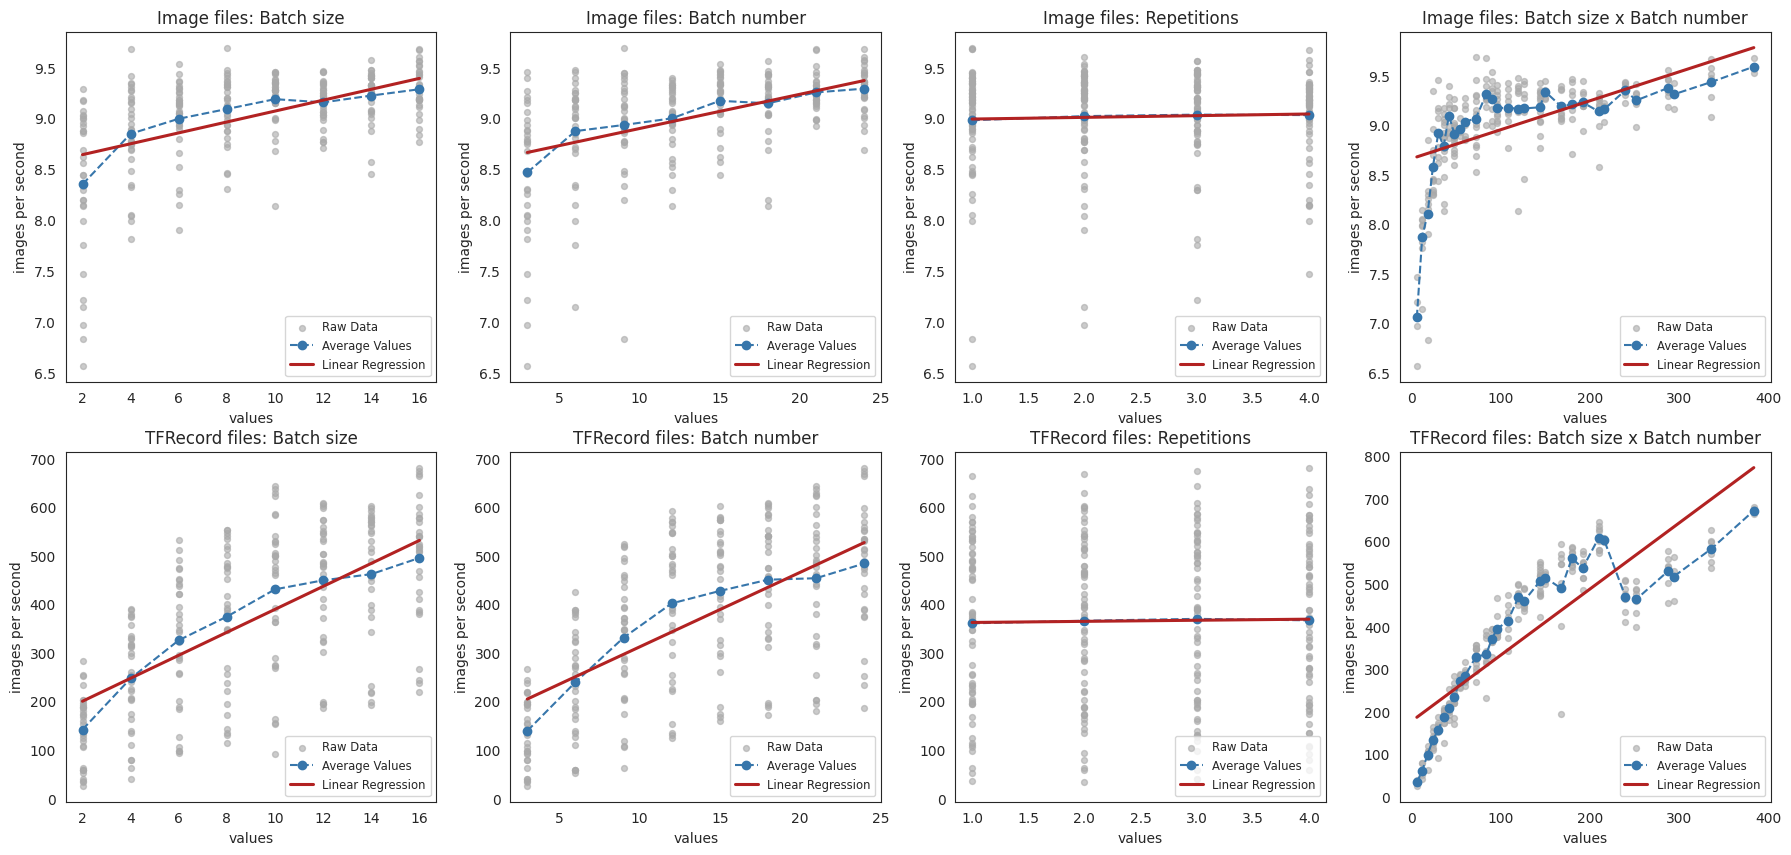

In [ ]:
# Functions for linear regression
def linearRegression(key):
    data = results["{}_raw".format(key)] # extract the data
    # define the x, y in the regression
    x = np.array([xy[0] for xy in data])
    y = np.array([xy[1] for xy in data])
    # apply linear regression
    slope, intercept, _, p_value, _ = scipy.stats.linregress(x, y)

    return intercept, slope, p_value

# set for each parameter value and for two type of data and save the regression results
keys = ['img_bs', 'img_ds', 'img_rep', 'img_size',
        'tf_bs', 'tf_ds', 'tf_rep', 'tf_size']

lrResults = np.zeros((3, 8))

for i, key in enumerate(keys):
    intercept, slope, p_value = linearRegression(key)
    lrResults[0][i], lrResults[1][i], lrResults[2][i] = intercept, slope, p_value

# Create the table with the results
from tabulate import tabulate

Cases = ["Image files", "Image files", "Image files", "Image files",
         "TFRecord files", "TFRecord files", "TFRecord files", "TFRecord files"]
Parameters = ["Batch size", "Batch number", "Repetitions", "Batch size x Batch number",
              "Batch size", "Batch number", "Repetitions", "Batch size x Batch number"]

table_data = []
for i in range(len(keys)):
    # Format each value to display only three decimal places
    intercept = f"{lrResults[0, i]:.3f}"
    coefficient = f"{lrResults[1, i]:.3f}"
    p_value = lrResults[2, i]
    table_data.append([Cases[i], Parameters[i], intercept, coefficient, p_value])

headers = ['Case', 'Parameter', 'Intercept', 'Coefficient', 'P-value']
table = tabulate(table_data, headers=headers, tablefmt='grid')
print(table)

# plot the raw data, avg data and linear regression results together
import seaborn as sns
sns.set_style("white")

fig, axes = plt.subplots(2, 4, figsize=(22, 10))

for i, key in enumerate(keys):
    raw_data = results["{}_raw".format(key)]
    raw_x = np.array([data[0] for data in raw_data])
    raw_y = np.array([data[1] for data in raw_data])

    avg_data = results["{}_avg".format(key)]
    avg_data_sort = sorted(avg_data, key=lambda x: x[0])
    avg_x = np.array([data[0] for data in avg_data_sort])
    avg_y = np.array([data[1] for data in avg_data_sort])
    intercept, slope = lrResults[0][i], lrResults[1][i]

    row, col = i // 4, i % 4
    ax = axes[row][col]

    ax.scatter(raw_x, raw_y, color='darkgray', alpha=0.6, s=18, label='Raw Data')
    ax.plot(avg_x, avg_y, color='#3776ab', marker = 'o', linestyle='--', label='Average Values')
    ax.plot(avg_x, intercept + slope * avg_x, color='firebrick', linewidth=2.2, label='Linear Regression')

    ax.set_xlabel('values')
    ax.set_ylabel('images per second')
    ax.set_title('{}: {}'.format(Cases[i], Parameters[i]))
    ax.legend(loc='lower right', fontsize='small')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket

Removing gs://bigdata-cw24-230048952-storage/result_240428-1036.pkl#1714300740262532...
Removing gs://bigdata-cw24-230048952-storage/result_240426-1625.pkl#1714148768002134...
Removing gs://bigdata-cw24-230048952-storage/result_240428-1759.pkl#1714327259627540...
Removing gs://bigdata-cw24-230048952-storage/result_240427-1153.pkl#1714218939953998...
Removing gs://bigdata-cw24-230048952-storage/result_240427-1148.pkl#1714218589766961...
Removing gs://bigdata-cw24-230048952-storage/result_240428-1040.pkl#1714303308747091...
Removing gs://bigdata-cw24-230048952-storage/result_240427-1324.pkl#1714224326971841...
Removing gs://bigdata-cw24-230048952-storage/result_240427-1326.pkl#1714226701367980...
Removing gs://bigdata-cw24-230048952-storage/result_240428-1803.pkl#1714327488393448...
Removing gs://bigdata-cw24-230048952-storage/result_240428-1810.pkl#1714327893114989...
Removing gs://bigdata-cw24-230048952-storage/result_240428-1812.pkl#1714329177328784...
Removing gs://bigdata-cw24-23004